# Sentiment Analysis with Deep Learning using BERT

## Exploratory Data Analysis and Preprocessing

In [1]:
import torch
import pandas as pd
from tqdm.notebook import tqdm

In [2]:
df = pd.read_csv('smile-annotations-final.csv', names=['id', 'text', 'category'])
df.set_index('id', inplace=True)

In [3]:
df.head()

,text,category
id,,
611857364396965889,@aandraous @britishmuseum @AndrewsAntonio Merc...,nocode
614484565059596288,Dorian Gray with Rainbow Scarf #LoveWins (from...,happy
614746522043973632,@SelectShowcase @Tate_StIves ... Replace with ...,happy
614877582664835073,@Sofabsports thank you for following me back. ...,happy
611932373039644672,@britishmuseum @TudorHistory What a beautiful ...,happy


In [4]:
df.category.value_counts()

nocode               1572
happy                1137
not-relevant          214
angry                  57
surprise               35
sad                    32
happy|surprise         11
happy|sad               9
disgust|angry           7
disgust                 6
sad|disgust             2
sad|angry               2
sad|disgust|angry       1
Name: category, dtype: int64

In [5]:
df = df[~df.category.str.contains('\|')]

In [6]:
df = df[df.category != 'nocode']

In [7]:
val_count = df.category.value_counts()

Text(0.5, 1.0, 'Sentiment Data Distribution')

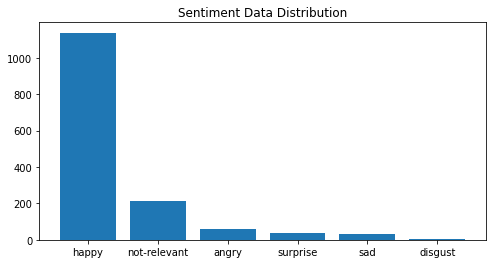

In [8]:
import matplotlib.pyplot as plt
plt.figure(figsize=(8,4))
plt.bar(val_count.index, val_count.values)
plt.title("Sentiment Data Distribution")

In [9]:
possible_labels = df.category.unique()

In [10]:
label_dict = {}
for index, possible_label in enumerate(possible_labels):
    label_dict[possible_label] = index

In [11]:
df['label'] = df.category.replace(label_dict)

In [12]:
df.head()

,text,category,label
id,,,
614484565059596288,Dorian Gray with Rainbow Scarf #LoveWins (from...,happy,0
614746522043973632,@SelectShowcase @Tate_StIves ... Replace with ...,happy,0
614877582664835073,@Sofabsports thank you for following me back. ...,happy,0
611932373039644672,@britishmuseum @TudorHistory What a beautiful ...,happy,0
611570404268883969,@NationalGallery @ThePoldarkian I have always ...,happy,0


## Training/Validation Split

In [13]:
from sklearn.model_selection import train_test_split

In [14]:
X_train, X_val, y_train, y_val = train_test_split(df.index.values, 
                                                  df.label.values, 
                                                  test_size=0.15, 
                                                  random_state=17, 
                                                  stratify=df.label.values)

In [15]:
df['data_type'] = ['not_set']*df.shape[0]

In [16]:
df.loc[X_train, 'data_type'] = 'train'
df.loc[X_val, 'data_type'] = 'val'

In [17]:
df.groupby(['category', 'label', 'data_type']).count()

text
category     label data_type      
angry        2     train        48
                   val           9
disgust      3     train         5
                   val           1
happy        0     train       966
                   val         171
not-relevant 1     train       182
                   val          32
sad          4     train        27
                   val           5
surprise     5     train        30
                   val           5

## Loading Tokenizer and Encoding our Data

In [18]:
pip install transformers

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 5.8 MB 29.4 MB/s 
     |████████████████████████████████| 7.6 MB 70.5 MB/s 
     |████████████████████████████████| 182 kB 80.5 MB/s 


In [19]:
from transformers import BertTokenizer
from torch.utils.data import TensorDataset

In [20]:
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased', 
                                          do_lower_case=True)

Downloading:   0%|          | 0.00/232k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/28.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/570 [00:00<?, ?B/s]

In [21]:
encoded_data_train = tokenizer.batch_encode_plus(
    df[df.data_type=='train'].text.values, 
    add_special_tokens=True, 
    return_attention_mask=True, 
    pad_to_max_length=True, 
    max_length=256, 
    return_tensors='pt'
)

encoded_data_val = tokenizer.batch_encode_plus(
    df[df.data_type=='val'].text.values, 
    add_special_tokens=True, 
    return_attention_mask=True, 
    pad_to_max_length=True, 
    max_length=256, 
    return_tensors='pt'
)


input_ids_train = encoded_data_train['input_ids']
attention_masks_train = encoded_data_train['attention_mask']
labels_train = torch.tensor(df[df.data_type=='train'].label.values)

input_ids_val = encoded_data_val['input_ids']
attention_masks_val = encoded_data_val['attention_mask']
labels_val = torch.tensor(df[df.data_type=='val'].label.values)

Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
/usr/local/lib/python3.8/dist-packages/transformers/tokenization_utils_base.py:2336: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(


In [22]:
dataset_train = TensorDataset(input_ids_train, attention_masks_train, labels_train)
dataset_val = TensorDataset(input_ids_val, attention_masks_val, labels_val)

In [23]:
len(dataset_train)

1258

In [24]:
len(dataset_val)

223

## Setting up BERT Pretrained Model

In [25]:
from transformers import BertForSequenceClassification

In [26]:
model = BertForSequenceClassification.from_pretrained("bert-base-uncased",
                                                      num_labels=len(label_dict),
                                                      output_attentions=False,
                                                      output_hidden_states=False)



Downloading:   0%|          | 0.00/440M [00:00<?, ?B/s]

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at

## Creating Data Loaders

In [27]:
from torch.utils.data import DataLoader, RandomSampler, SequentialSampler

In [28]:
batch_size = 32

dataloader_train = DataLoader(dataset_train, 
                              sampler=RandomSampler(dataset_train), 
                              batch_size=batch_size)

dataloader_validation = DataLoader(dataset_val, 
                                   sampler=RandomSampler(dataset_val), 
                                   batch_size=batch_size)

## Setting Up Optimiser and Scheduler

In [29]:
from transformers import AdamW, get_linear_schedule_with_warmup

In [30]:
optimizer = AdamW(model.parameters(),
                  lr=1e-5, 
                  eps=1e-8)

/usr/local/lib/python3.8/dist-packages/transformers/optimization.py:306: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


In [31]:
epochs = 5

scheduler = get_linear_schedule_with_warmup(optimizer, 
                                            num_warmup_steps=0,
                                            num_training_steps=len(dataloader_train)*epochs)

## Defining our Performance Metrics

In [32]:
import numpy as np

In [33]:
from sklearn.metrics import f1_score

In [34]:
def f1_score_func(preds, labels):
    preds_flat = np.argmax(preds, axis=1).flatten()
    labels_flat = labels.flatten()
    return f1_score(labels_flat, preds_flat, average='weighted')

In [35]:
def accuracy_per_class(preds, labels):
    label_dict_inverse = {v: k for k, v in label_dict.items()}
    
    preds_flat = np.argmax(preds, axis=1).flatten()
    labels_flat = labels.flatten()

    for label in np.unique(labels_flat):
        y_preds = preds_flat[labels_flat==label]
        y_true = labels_flat[labels_flat==label]
        print(f'Class: {label_dict_inverse[label]}')
        print(f'Accuracy: {len(y_preds[y_preds==label])}/{len(y_true)}\n')

## Creating our Training Loop

In [36]:
import random

seed_val = 17
random.seed(seed_val)
np.random.seed(seed_val)
torch.manual_seed(seed_val)
torch.cuda.manual_seed_all(seed_val)

In [37]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)

print(device)

cuda


In [38]:
def evaluate(dataloader_val):

    model.eval()
    
    loss_val_total = 0
    predictions, true_vals = [], []
    
    for batch in dataloader_val:
        
        batch = tuple(b.to(device) for b in batch)
        
        inputs = {'input_ids':      batch[0],
                  'attention_mask': batch[1],
                  'labels':         batch[2],
                 }

        with torch.no_grad():        
            outputs = model(**inputs)
            
        loss = outputs[0]
        logits = outputs[1]
        loss_val_total += loss.item()

        logits = logits.detach().cpu().numpy()
        label_ids = inputs['labels'].cpu().numpy()
        predictions.append(logits)
        true_vals.append(label_ids)
    
    loss_val_avg = loss_val_total/len(dataloader_val) 
    predictions = np.concatenate(predictions, axis=0)
    true_vals = np.concatenate(true_vals, axis=0)
            
    return loss_val_avg, predictions, true_vals

In [39]:
for epoch in tqdm(range(1, epochs+1)):
    
    model.train()
    
    loss_train_total = 0

    progress_bar = tqdm(dataloader_train, desc='Epoch {:1d}'.format(epoch), leave=False, disable=False)
    
    
    for batch in progress_bar:

        model.zero_grad()  #backward pass
        
        #add batch to GPU
        batch = tuple(b.to(device) for b in batch)   
        
        #Unpack the inputs from dataloader
        inputs = {'input_ids':      batch[0],
                  'attention_mask': batch[1],
                  'labels':         batch[2],
                 }       

        outputs = model(**inputs) #forward pass
        
        loss = outputs[0]
        loss_train_total += loss.item()
        loss.backward()   #backward pass to calculate gradients

        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)

        optimizer.step()
        scheduler.step()
        
        progress_bar.set_postfix({'training_loss': '{:.3f}'.format(loss.item()/len(batch))})
         
        
    torch.save(model.state_dict(), f'finetuned_BERT_epoch_{epoch}.model')
        
    tqdm.write(f'\nEpoch {epoch}')
    
    loss_train_avg = loss_train_total/len(dataloader_train)            
    tqdm.write(f'Training loss: {loss_train_avg}')
    
    #evaluating model
    val_loss, predictions, true_vals = evaluate(dataloader_validation)
    val_f1 = f1_score_func(predictions, true_vals)
    tqdm.write(f'Validation loss: {val_loss}')
    tqdm.write(f'F1 Score (Weighted): {val_f1}')

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch 1:   0%|          | 0/40 [00:00<?, ?it/s]


Epoch 1
Training loss: 1.084840227663517
Validation loss: 0.8347735575267247
F1 Score (Weighted): 0.6656119824269878


Epoch 2:   0%|          | 0/40 [00:00<?, ?it/s]


Epoch 2
Training loss: 0.7216250963509083
Validation loss: 0.6922861337661743
F1 Score (Weighted): 0.6963550649649304


Epoch 3:   0%|          | 0/40 [00:00<?, ?it/s]


Epoch 3
Training loss: 0.6058215364813805
Validation loss: 0.6239117171083178
F1 Score (Weighted): 0.7171117606235319


Epoch 4:   0%|          | 0/40 [00:00<?, ?it/s]


Epoch 4
Training loss: 0.5222933419048786
Validation loss: 0.5956427752971649
F1 Score (Weighted): 0.7442717877673366


Epoch 5:   0%|          | 0/40 [00:00<?, ?it/s]


Epoch 5
Training loss: 0.48204106763005256
Validation loss: 0.5766918574060712
F1 Score (Weighted): 0.7551928465424776


In [40]:
#last batch
accuracy_per_class(predictions, true_vals)

Class: happy
Accuracy: 169/171

Class: not-relevant
Accuracy: 11/32

Class: angry
Accuracy: 0/9

Class: disgust
Accuracy: 0/1

Class: sad
Accuracy: 0/5

Class: surprise
Accuracy: 0/5



# **Model Evaluation on Validation Data**

In [41]:
_, predictions, true_vals = evaluate(dataloader_validation)

In [42]:
accuracy_per_class(predictions, true_vals)

Class: happy
Accuracy: 169/171

Class: not-relevant
Accuracy: 11/32

Class: angry
Accuracy: 0/9

Class: disgust
Accuracy: 0/1

Class: sad
Accuracy: 0/5

Class: surprise
Accuracy: 0/5



In [43]:
predictions

array([[ 3.9762983 ,  0.07791132, -0.59378517, -1.0038584 , -0.6890831 ,
        -0.929489  ],
       [ 1.4672898 ,  1.0800787 , -0.23348834, -1.5048736 , -0.7868003 ,
        -1.0596755 ],
       [ 3.4584205 ,  0.10799191, -0.76779157, -1.1052876 , -0.8337245 ,
        -0.69472754],
       ...,
       [ 3.5421534 ,  0.2995305 , -0.8803034 , -1.5486335 , -0.8535629 ,
        -0.8893002 ],
       [ 1.1948237 ,  0.68878394, -0.13926283, -1.3144557 , -0.5127895 ,
        -0.95377386],
       [ 1.4150289 ,  1.1755459 , -0.4047233 , -1.6013023 , -0.81318957,
        -1.0055512 ]], dtype=float32)

In [44]:
true_vals

array([0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 5, 0, 0,
       0, 0, 0, 4, 0, 1, 1, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 4, 0,
       0, 0, 0, 2, 4, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0,
       0, 0, 1, 2, 0, 0, 0, 0, 4, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 4, 0, 2, 0,
       0, 1, 5, 0, 0, 0, 0, 0, 2, 0, 0, 1, 0, 0, 0, 0, 1, 0, 2, 1, 0, 0,
       0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0,
       1, 1, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 5,
       1, 0, 1, 0, 0, 2, 0, 3, 0, 5, 0, 0, 5, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 2, 0, 0,
       1, 1, 1])

In [45]:
true_vals.shape

(223,)

In [46]:
predictions.shape

(223, 6)

In [47]:
y_true=true_vals.flatten()

In [48]:
y_pred=predictions.flatten()

In [49]:
preds_flat = np.argmax(predictions, axis=1).flatten()
#labels_flat = labels.flatten()

In [50]:
from sklearn.metrics import classification_report

print(classification_report(true_vals, preds_flat))

              precision    recall  f1-score   support

           0       0.84      0.99      0.91       171
           1       0.50      0.34      0.41        32
           2       0.00      0.00      0.00         9
           3       0.00      0.00      0.00         1
           4       0.00      0.00      0.00         5
           5       0.00      0.00      0.00         5

    accuracy                           0.81       223
   macro avg       0.22      0.22      0.22       223
weighted avg       0.72      0.81      0.76       223



/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [51]:
from sklearn.metrics import confusion_matrix

#Generate the confusion matrix
cf_matrix = confusion_matrix(true_vals, preds_flat)

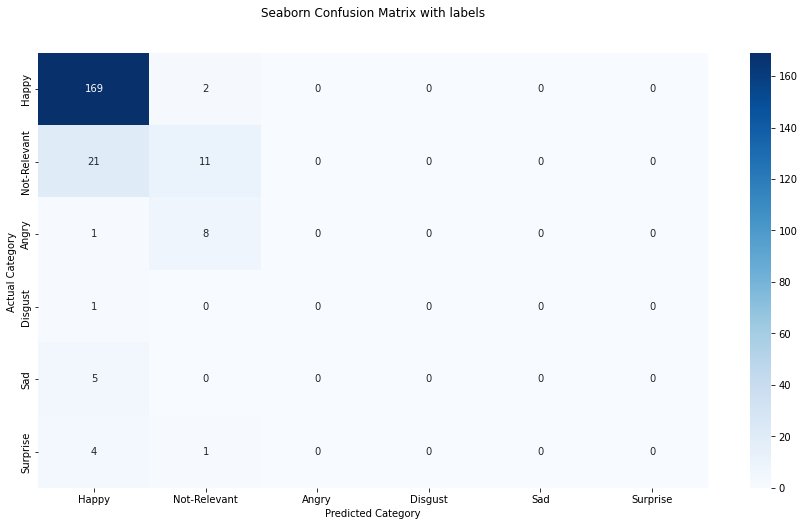

In [52]:
import seaborn as sns
import matplotlib.pyplot as plt
plt.figure(figsize=(15, 8))
ax = sns.heatmap(cf_matrix, annot=True, cmap='Blues',fmt="d")

ax.set_title('Seaborn Confusion Matrix with labels\n\n');
ax.set_xlabel('Predicted Category')
ax.set_ylabel('Actual Category ');

## Ticket labels - List must be in alphabetical order
ax.xaxis.set_ticklabels(["Happy","Not-Relevant","Angry","Disgust","Sad","Surprise"])
ax.yaxis.set_ticklabels(["Happy","Not-Relevant","Angry","Disgust","Sad","Surprise"])

## Display the visualization of the Confusion Matrix.
plt.show()